# Assignment Week 3 - Group 5

### Noelani Roy, Yihong Qiu, Cosimo Cambi, Craig Perkins

Using Tree Based ML Models and Model Optimization

You will be using the same dataset that you had used for Week 2  Assignment (to build the regression models) for Week 3 Assignment as well. In this week's Assignment, you are required to predict an outcome using the tree based models that we discussed in the class today. 

Demonstrate the use of Decision Tree, Random Forest, GBM and XGBoost algorithms.
Evaluate and compare the models in terms of pre-processing, accuracy, run time etc.
Model Optimization techniques you used for hyper-parameter tuning
Discuss pros and cons of each model
Please note that points will be given based on your clear explanations to above questions and not on any code snippets. Therefore, answer the questions clearly in text. 
If you are submitting a notebook, please make sure to clean-up unnecessarily verbose outputs in the code before converting to a PDF
Note: Ensure you have understood the concepts behind regression and tree based model classification by now. For week 6 group presentation, you will be asked to demonstrate all of the models you have built thus far and do a comparison between the models.


# Data Preparation

## Data Selection

### Import libraries

In [1]:
# main libraries
import pandas as pd
import numpy as np
from numpy import mean, where
from datetime import date
import geopy.distance
from math import sin, cos, sqrt, atan2, radians, log
from collections import Counter

In [2]:
# visual libraries
import seaborn as sns 
import matplotlib.pyplot as plt

In [3]:
# sklearn libraries
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,RepeatedStratifiedKFold
from sklearn.datasets import make_classification
from sklearn import tree, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, roc_auc_score

/Users/venusqiu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
# imblearn libraries
import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

### Read data

In [5]:
df_1 = pd.read_csv("../fraudTrain.csv")
df_2 = pd.read_csv("../fraudTest.csv")
fraud_df = df_1.append(df_2)

In [6]:
fraud_df.shape

(1852394, 23)

## Data Preprocessing

In [7]:
# Checking for missing values
fraud_df.isnull().any().sum()

0

In [8]:
# Checking for data types
fraud_df.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [9]:
# Checking for unique values
fraud_df.nunique()

Unnamed: 0               1296675
trans_date_trans_time    1819551
cc_num                       999
merchant                     693
category                      14
amt                        60616
first                        355
last                         486
gender                         2
street                       999
city                         906
state                         51
zip                          985
lat                          983
long                         983
city_pop                     891
job                          497
dob                          984
trans_num                1852394
unix_time                1819583
merch_lat                1754157
merch_long               1809753
is_fraud                       2
dtype: int64

### Formatting and cleansing

In [10]:
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def calculate_distance(row):
    coords_1 = (row['lat'], row['long'])
    coords_2 = (row['merch_lat'], row['merch_long'])
    return geopy.distance.geodesic(coords_1, coords_2).km

# Answer from https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
# The answers above are based on the Haversine formula, which assumes the earth is a sphere,
# which results in errors of up to about 0.5% (according to help(geopy.distance)). 
# Vincenty distance uses more accurate ellipsoidal models such as WGS-84, and is implemented in geopy. For example,
def calculate_distance2(row):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(row['lat'])
    lon1 = radians(row['long'])
    lat2 = radians(row['merch_lat'])
    lon2 = radians(row['merch_long'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    print(distance)


# First derive columns
if 'trans_date_trans_time' in fraud_df.columns:
    fraud_df['txn_datetime'] =  pd.to_datetime(fraud_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

if 'dob' in fraud_df.columns:
    fraud_df['age'] = [calculate_age(d) for d in pd.to_datetime(fraud_df['dob'], format='%Y-%m-%d')]
    
if set(['lat', 'long', 'merch_lat', 'merch_long']).issubset(set(fraud_df.columns)):
     fraud_df['distance'] = [calculate_distance(row) for _, row in fraud_df.iterrows()]
        
fraud_df['hour'] = fraud_df['txn_datetime'].dt.hour
fraud_df['day'] = fraud_df['txn_datetime'].dt.day
fraud_df['month'] = fraud_df['txn_datetime'].dt.month
fraud_df['year'] = fraud_df['txn_datetime'].dt.year

#fraud_df['log_amt'] = [log(n) for n in fraud_df['amt']]    

In [11]:
#Saving the new data frame since it take a while to create the new ones before after do the above steps and before the columns are dropped. 
fraud_df.to_csv('grp5_fraud_mod.csv')

In [5]:
#Read Modified Fraud File here to skip the feature generation...which can take a while
fraud_df = pd.read_csv("grp5_fraud_mod.csv")

In [6]:
# Drop the columns used to derive new features
fraud_df.drop([
    'Unnamed: 0',
    'Unnamed: 0.1',
    'trans_num',
    'trans_date_trans_time',
    'cc_num',
    'merchant',
    'unix_time',
    'first',
    'last',
    'street',
    'city',
    'state',
    'zip',
    'job',
    'dob',
    'lat',
    'long',
    'merch_lat',
    'merch_long',
    'txn_datetime'
], axis=1, errors='ignore', inplace=True)


In [7]:
fraud_df.head()

category     amt gender  city_pop  is_fraud  age    distance  hour  \
0       misc_net    4.97      F      3495         0   32   78.773821     0   
1    grocery_pos  107.23      F       149         0   42   30.216618     0   
2  entertainment  220.11      M      4154         0   58  108.102912     0   
3  gas_transport   45.00      M      1939         0   53   95.685115     0   
4       misc_pos   41.96      M        99         0   34   77.702395     0   

   day  month  year  
0    1      1  2019  
1    1      1  2019  
2    1      1  2019  
3    1      1  2019  
4    1      1  2019

### Check fraud and non fraud rates

In [8]:
All = fraud_df.shape[0]
fraud = fraud_df[fraud_df['is_fraud'] == 1]
nonFraud = fraud_df[fraud_df['is_fraud'] == 0]

a = len(fraud)/All
b = len(nonFraud)/All

print('frauds :',round(a,2)*100,'%')
print('non frauds :',round(b,2)*100,'%')

frauds : 1.0 %
non frauds : 99.0 %


### Encoding

In [9]:
#create a list to hold our categorical columns and one to hold our numerical columns
cat_col = ['category','gender',]

#This one hot encodes the categorical columns and create a new variable to hold the nex column headers
if len(cat_col)>0: 
    cat_onehotencode = pd.get_dummies(fraud_df[cat_col],drop_first = True) #drop gender_F because F and M are correlated
    cat_col_onehotencode = list(cat_onehotencode.columns)
    fraud_df = pd.concat([fraud_df,cat_onehotencode], axis = 1)

else:
    cat_col_onehotencode = []

In [10]:
fraud_df[cat_col_onehotencode].head()

category_food_dining  category_gas_transport  category_grocery_net  \
0                     0                       0                     0   
1                     0                       0                     0   
2                     0                       0                     0   
3                     0                       1                     0   
4                     0                       0                     0   

   category_grocery_pos  category_health_fitness  category_home  \
0                     0                        0              0   
1                     1                        0              0   
2                     0                        0              0   
3                     0                        0              0   
4                     0                        0              0   

   category_kids_pets  category_misc_net  category_misc_pos  \
0                   0                  1                  0   
1                   0                  0                  0   
2                   0                  0                  0   
3                   0                  0                  0   
4                   0                  0                  1   

   category_personal_care  category_shopping_net  category_shopping_pos  \
0                       0                      0                      0   
1                       0                      0                      0   
2                       0                      0                      0   
3                       0                      0                      0   
4                       0                      0                      0   

   category_travel  gender_M  
0                0         0  
1                0         0  
2                0         1  
3                0         1  
4                0         1

In [11]:
fraud_df = fraud_df.drop(['category','gender'],axis=1)

## Data Transformation 

### Standardize the data

In [12]:
fraud_df.head()

amt  city_pop  is_fraud  age    distance  hour  day  month  year  \
0    4.97      3495         0   32   78.773821     0    1      1  2019   
1  107.23       149         0   42   30.216618     0    1      1  2019   
2  220.11      4154         0   58  108.102912     0    1      1  2019   
3   45.00      1939         0   53   95.685115     0    1      1  2019   
4   41.96        99         0   34   77.702395     0    1      1  2019   

   category_food_dining  ...  category_health_fitness  category_home  \
0                     0  ...                        0              0   
1                     0  ...                        0              0   
2                     0  ...                        0              0   
3                     0  ...                        0              0   
4                     0  ...                        0              0   

   category_kids_pets  category_misc_net  category_misc_pos  \
0                   0                  1                  0   
1                   0                  0                  0   
2                   0                  0                  0   
3                   0                  0                  0   
4                   0                  0                  1   

   category_personal_care  category_shopping_net  category_shopping_pos  \
0                       0                      0                      0   
1                       0                      0                      0   
2                       0                      0                      0   
3                       0                      0                      0   
4                       0                      0                      0   

   category_travel  gender_M  
0                0         0  
1                0         0  
2                0         1  
3                0         1  
4                0         1  

[5 rows x 23 columns]

In [13]:
features = ['city_pop', 'age', 'distance', 'hour', 'day',
       'month', 'year', 'amt','category_food_dining',
       'category_gas_transport','category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_M']
target = ['is_fraud']
# Separating out the features
x = fraud_df.loc[:, features].values
# Separating out the target
y = fraud_df.loc[:,target].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

### Data splitting

In [14]:
count = len(fraud_df)
train = fraud_df[:count]
test = fraud_df[count:]
x = train.drop(['is_fraud'], axis=1)
y = train['is_fraud'].astype('int')
test = test.drop(['is_fraud'], axis=1)
x_train,x_test, y_train,y_test = train_test_split(x, y, test_size=0.3,random_state=123)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1296675, 22)
(1296675,)
(555719, 22)
(555719,)


### Resampling (SMOTE)

Counter({0: 99000, 1: 1000})
Counter({0: 59400, 1: 29700})


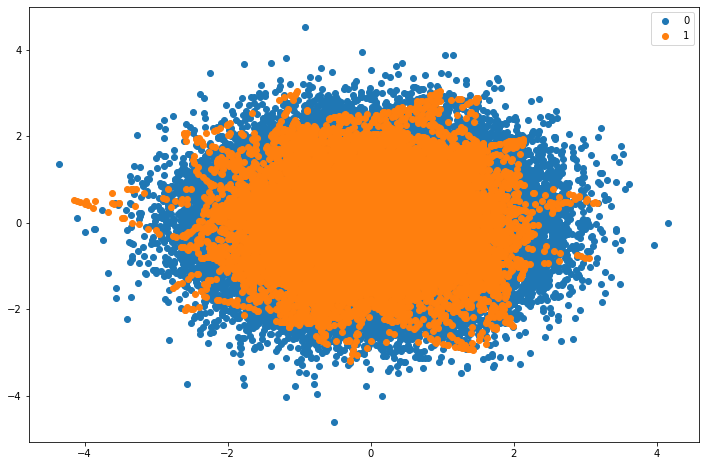

In [71]:
# Oversample with SMOTE and random undersample for imbalanced dataset
# Define dataset
x_train, y_train = make_classification(n_samples=100000, n_features=22, n_redundant=2, n_clusters_per_class=2, 
                           weights=[0.99], flip_y=0, random_state=1)

# Summarize class distribution
counter = Counter(y_train)
print(counter)

# Define pipeline
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
x_train, y_train = pipeline.fit_resample(x_train, y_train)

# Summarize the new class distribution
counter = Counter(y_train)
print(counter)


# Scatter plot of examples by class label
plt.figure(figsize=(12, 8))
for label, _ in counter.items():
    row_ix = where(y_train == label)[0]
    plt.scatter(x_train[row_ix, 0], x_train[row_ix, 1], label=str(label))

plt.legend()
plt.show()

In [72]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(89100, 22)
(89100,)
(555719, 22)
(555719,)


In [41]:
# Grid search k value for SMOTE oversampling and random undersample for imbalanced classification
# Define dataset
x_train1, y_train1 = make_classification(n_samples=100000, n_features=22, n_redundant=0, n_clusters_per_class=1, 
                           weights=[0.80], flip_y=0, random_state=1)

k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
# Define pipeline
    model = DecisionTreeClassifier()
    over = SMOTE(sampling_strategy=0.3, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    
# Evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, x_train1, y_train1, scoring='roc_auc', cv=cv, n_jobs=-1)
    print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.862
Mean ROC AUC: 0.864
Mean ROC AUC: 0.861
Mean ROC AUC: 0.862
Mean ROC AUC: 0.864
Mean ROC AUC: 0.862
Mean ROC AUC: 0.861


# Tree-based Models

## Decision Tree

In [18]:
# Train Decision Tree Model
DT = tree.DecisionTreeClassifier(criterion='gini', max_depth= 4, max_features = 'sqrt', random_state=20) 

DT.fit(x_train, y_train)
DT.score(x_train, y_train)

# Predict Output
DT_pred = DT.predict(x_test)

# Accuracy Score on test dataset
DT_accuracy = metrics.accuracy_score(y_test, DT_pred)

print("Accuracy:", round(DT_accuracy,2)*100,'%')

DT_probs = DT.predict_proba(x_test)[:, 1]

# Calculate roc auc
DT_roc_value = roc_auc_score(y_test, DT_probs)
print('\nROC AUC : ', round(DT_roc_value,2))

Accuracy: 91.0 %

ROC AUC :  0.55


### Confusion Matrix

Confusion matrix : 
 [[502502  50321]
 [  2240    656]]
Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95    552823
           1       0.01      0.23      0.02      2896

    accuracy                           0.91    555719
   macro avg       0.50      0.57      0.49    555719
weighted avg       0.99      0.91      0.95    555719



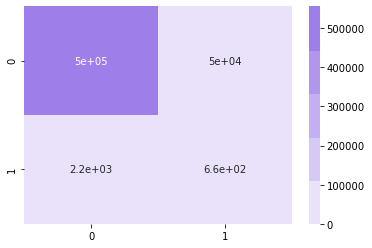

In [19]:
# confusion matrix
DTmatrix = confusion_matrix(y_test, DT_pred)
print('Confusion matrix : \n',DTmatrix)

# classification report for precision, recall f1-score and accuracy
DTmatrix1 = classification_report(y_test,DT_pred)
print('Classification report : \n',DTmatrix1)

cmap =  sns.diverging_palette(150, 275, s=80, l=60, n=10)
sns.heatmap(DTmatrix, annot=True, vmin=0, vmax=555719, center= 0, cmap=cmap)
plt.show()

## Feature Importances

In [20]:
# Extract feature importances
DT_Feature_Imp = pd.DataFrame({'features': list(features),
                   'importance': DT.feature_importances_}).\
                    sort_values('importance', ascending = False)
DT_Feature_Imp.head()

features  importance
11    category_grocery_pos    0.410944
17  category_personal_care    0.276857
15       category_misc_net    0.195582
5                    month    0.072787
8     category_food_dining    0.013833

### Visualization of Decision Tree

In [21]:
fig = plt.figure(figsize=(16,8), dpi=900)
treeplot = tree.plot_tree(DT, 
                   feature_names=features,  
                   class_names=['0','1'],
                   filled=True)

## Random Forest

In [298]:
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}
#random_grid


In [287]:
#from sklearn.model_selection import RandomizedSearchCV
# First create the base model to tune
#rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter =100, cv = 3, verbose=2, random_state=42, n_jobs = -1)


In [293]:
#rf_random.fit(x_train, y_train)
#rf_random.best_params_

#best_random = rf_random.best_estimator_
#random_accuracy = evaluate(best_random, x_test, y_test)

In [294]:
#random_accuracy

In [280]:
#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [30, 50, 60],
#    'max_features': [10, 20],
#    'min_samples_leaf': [3, 4, 5],
#    'min_samples_split': [8, 10, 12],
#    'n_estimators': [100, 200, 300, 500]
#}


#from sklearn.model_selection import GridSearchCV
#rf = RandomForestClassifier()
#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [295]:
#grid_search.fit(x_train, y_train)
#grid_search.best_params_

#best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, x_test, y_test)


In [296]:
#grid_accuracy

In [ ]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [22]:
# Train Random Forest Model
RF = RandomForestClassifier(n_estimators=800, bootstrap = True, oob_score = True, n_jobs=1, criterion= 'entropy',
                            max_features = 'sqrt', max_depth= 3, random_state= 42)
RF.fit(x_train, y_train)

# number of trees used
print('Number of Trees used : ', RF.n_estimators)

# Predict Output
RF_pred = RF.predict(x_test)

# Accuracy Score on test dataset
RF_accuracy = accuracy_score(y_test,RF_pred)
print('Accuracy: %.2f%%' % (RF_accuracy * 100.0))

RF_probs = RF.predict_proba(x_test)[:, 1]

# Calculate roc auc
RF_roc_value = roc_auc_score(y_test, RF_probs)
print('\nROC AUC : ', round(RF_roc_value,2))

Number of Trees used :  800

Accuracy_score on test dataset :  99.0 %

ROC AUC :  0.61


### Confusion Matrix

Confusion matrix : 
 [[550984   1839]
 [  2884     12]]
Classification report : 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    552823
           1       0.01      0.00      0.01      2896

    accuracy                           0.99    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      0.99      0.99    555719



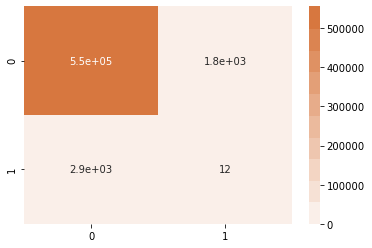

In [23]:
# confusion matrix
RFmatrix = confusion_matrix(y_test, RF_pred)
print('Confusion matrix : \n',RFmatrix)

# classification report for precision, recall f1-score and accuracy
RFmatrix1 = classification_report(y_test,RF_pred)
print('Classification report : \n',RFmatrix1)

cmap =  sns.diverging_palette(250, 30, s=80, l=60, n=20)
sns.heatmap(RFmatrix, annot=True,  vmin=0, vmax=555719, center= 0, cmap=cmap)
plt.show()

### Feature Importances

In [24]:
# Extract feature importances
RF_Feature_Imp = pd.DataFrame({'features': list(features),
                   'importance': RF.feature_importances_}).\
                    sort_values('importance', ascending = False)
RF_Feature_Imp.head()

features  importance
11    category_grocery_pos    0.500282
9   category_gas_transport    0.265104
17  category_personal_care    0.067616
15       category_misc_net    0.061180
18   category_shopping_net    0.022008

In [25]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (16,10), dpi=800)
tree.plot_tree(RF.estimators_[50],
               feature_names = features, 
               class_names=['0','1'],
               filled = True);

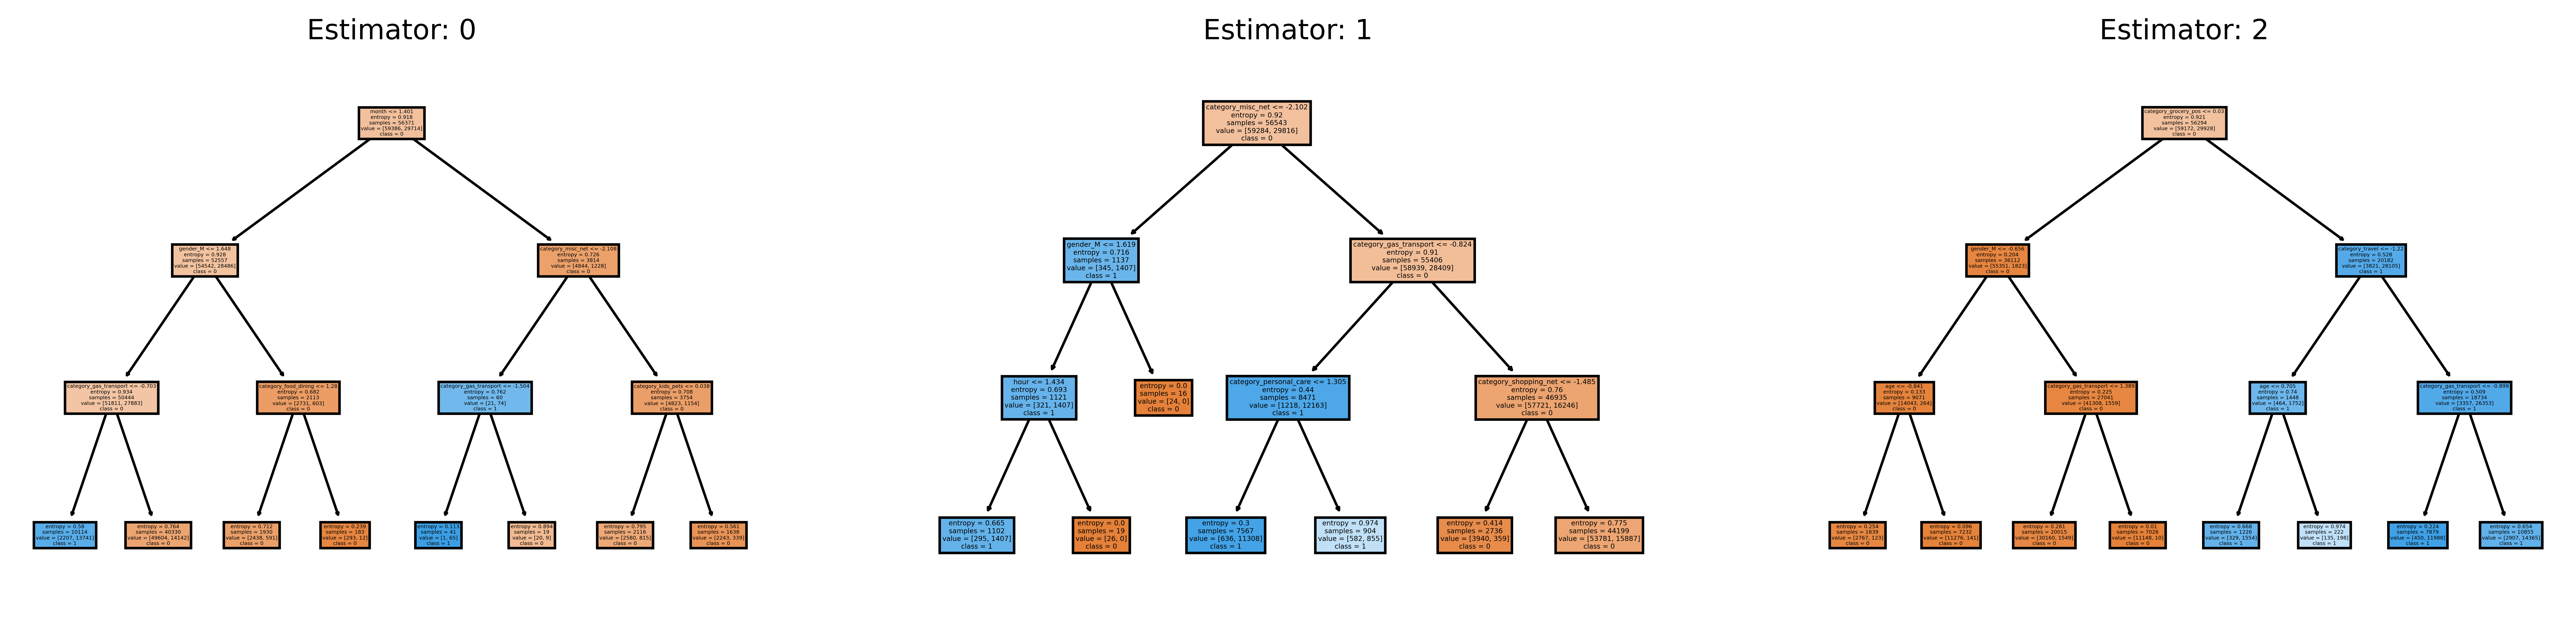

In [26]:
fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize = (18,4), dpi=900)
for index in range(0, 3):
    tree.plot_tree(RF.estimators_[index],
                   feature_names = features, 
                   class_names=['0','1'],
                   filled = True,
                   ax = axes[index]);
    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)

## GBM

In [34]:
GBM = GradientBoostingClassifier(n_estimators=1000, max_depth=4, loss='exponential', learning_rate=0.5,
                                 criterion='friedman_mse', min_weight_fraction_leaf=0.2, min_impurity_decrease=0.2,
                                 random_state=20, max_features=22, warm_start=True)
GBM.fit(x_train,y_train)

# number of trees used
print('Number of Trees used : ', GBM.n_estimators)

# Predict Output
GBM_pred = GBM.predict(x_test)

# Accuracy Score on test dataset
GBM_accuracy = accuracy_score(y_test,GBM_pred)
print('Accuracy: %.2f%%' % (GBM_accuracy * 100.0))

GBM_probs = GBM.predict_proba(x_test)[:, 1]

# Calculate roc auc
GBM_roc_value = roc_auc_score(y_test, GBM_probs)
print('\nROC AUC : ', round(GBM_roc_value,2))

Number of Trees used :  1000

Accuracy_score on test dataset :  90.0 %

ROC AUC :  0.58


## Confusion Matrix

Confusion matrix : 
 [[500658  52165]
 [  2228    668]]
Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95    552823
           1       0.01      0.23      0.02      2896

    accuracy                           0.90    555719
   macro avg       0.50      0.57      0.49    555719
weighted avg       0.99      0.90      0.94    555719



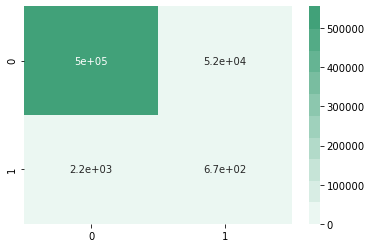

In [35]:
# confusion matrix
GBMmatrix = confusion_matrix(y_test, GBM_pred)
print('Confusion matrix : \n',GBMmatrix)

# classification report for precision, recall f1-score and accuracy
GBMmatrix1 = classification_report(y_test,GBM_pred)
print('Classification report : \n',GBMmatrix1)

cmap =  sns.diverging_palette(180, 150, s=80, l=60, n=20)
sns.heatmap(GBMmatrix, annot=True,  vmin=0, vmax=555719, center= 0, cmap=cmap)
plt.show()

## Feature Importances

In [36]:
# Extract feature importances
GBM_Feature_Imp = pd.DataFrame({'features': list(features),
                   'importance': GBM.feature_importances_}).\
                    sort_values('importance', ascending = False)
GBM_Feature_Imp.head()

features  importance
11    category_grocery_pos    0.916555
15       category_misc_net    0.033101
9   category_gas_transport    0.006270
3                     hour    0.003963
18   category_shopping_net    0.003224

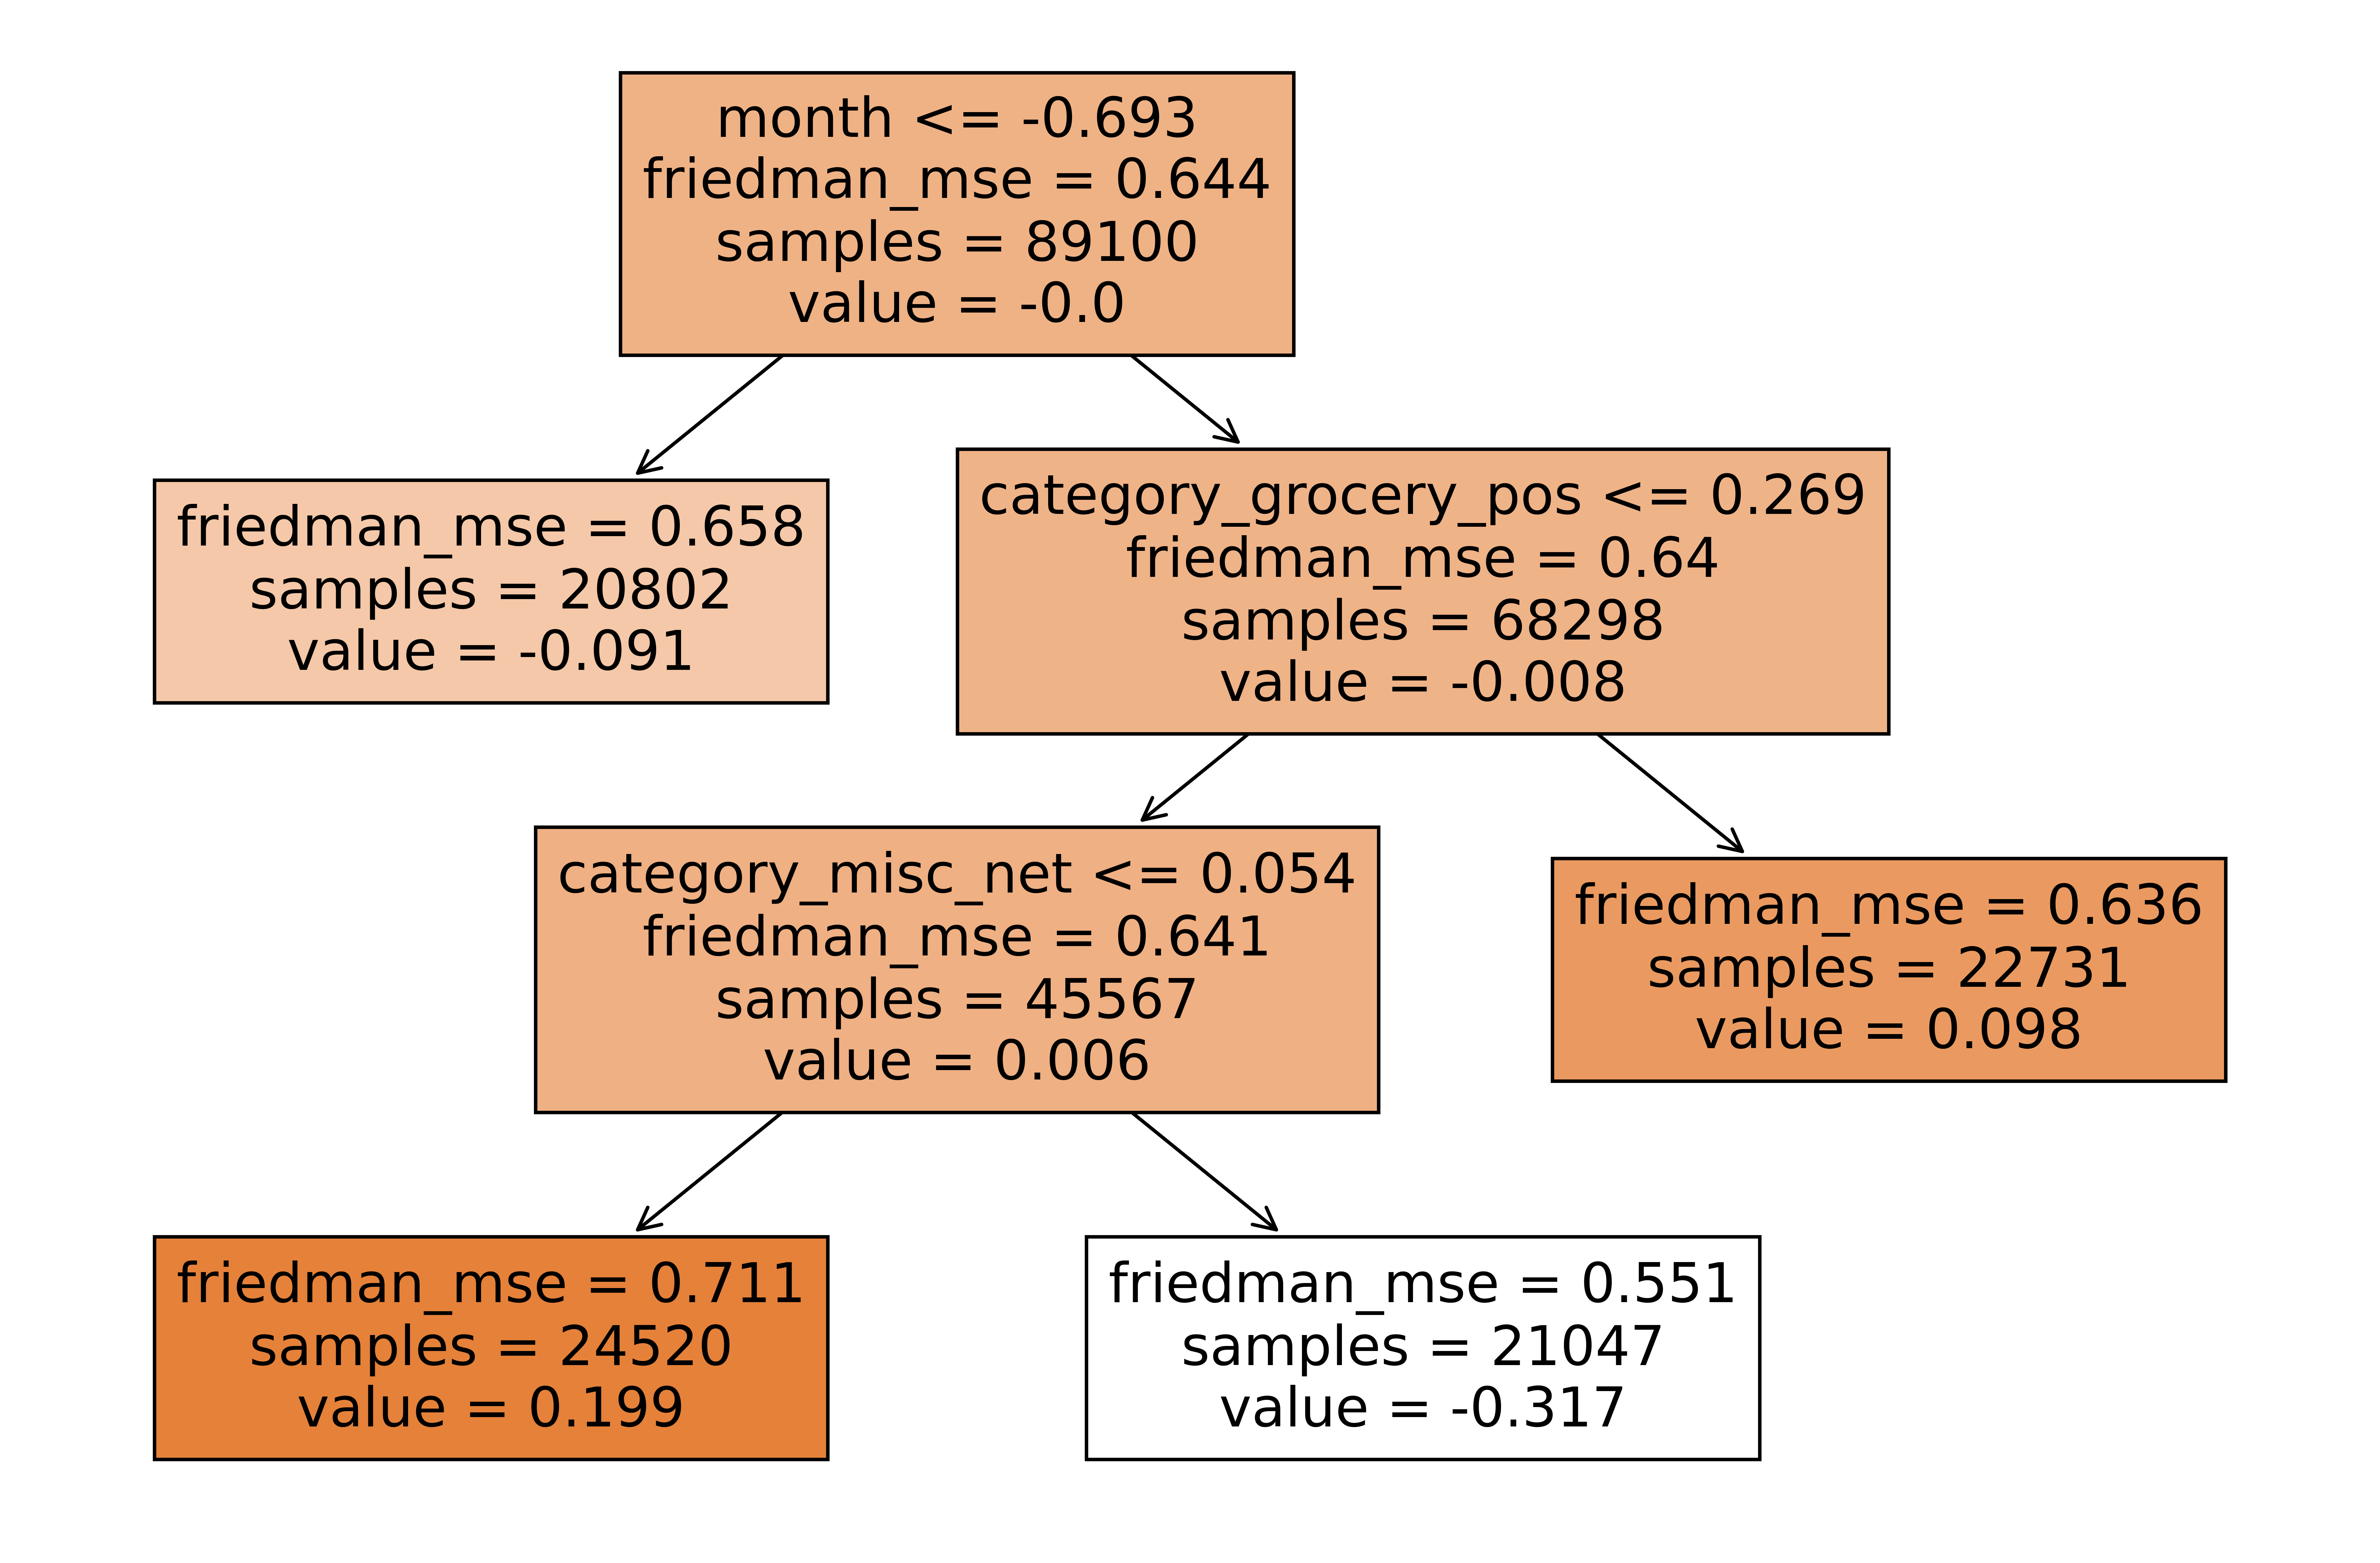

In [37]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,8), dpi=800)
tree.plot_tree(GBM.estimators_[30,0],     # Get the tree number 30
               feature_names = features, 
               class_names=['0','1'],
               filled = True);

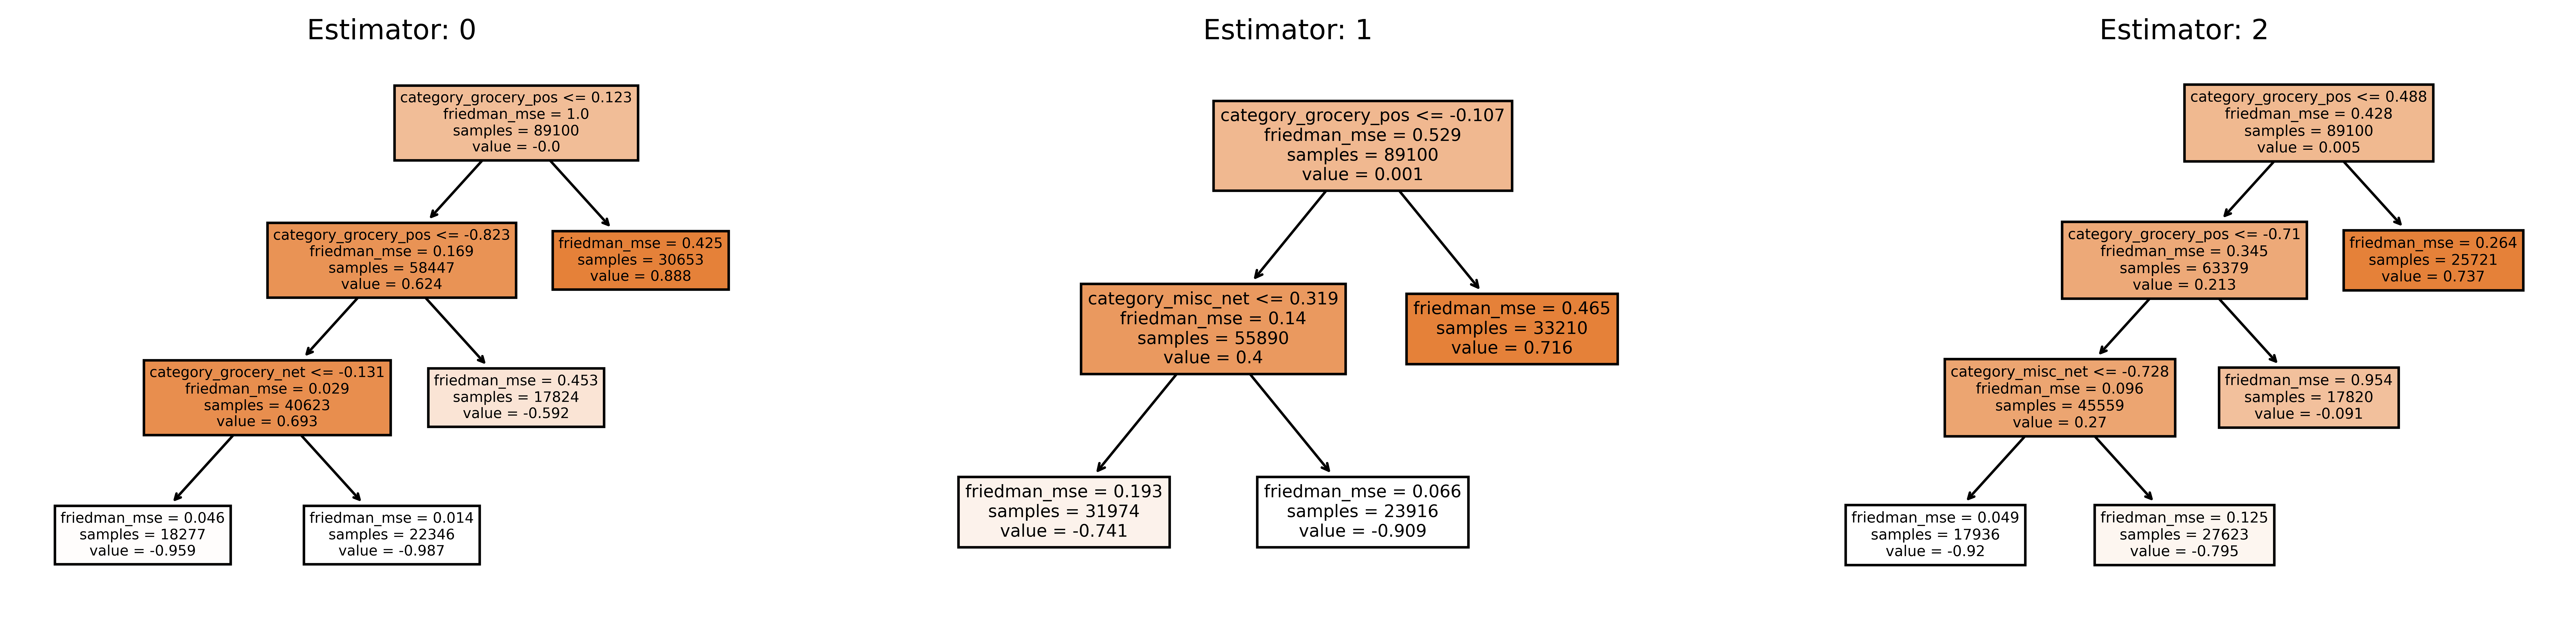

In [38]:
fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize = (18,4), dpi=900)
for index in range(0, 3):
    tree.plot_tree(GBM.estimators_[index,0],
                   feature_names = features, 
                   class_names=['0','1'],
                   filled = True,
                   ax = axes[index]);
    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)

## XGBoost

In [100]:
count = len(fraud_df)
train2 = fraud_df[:count]
test2 = fraud_df[count:]
x2 = train2.drop(['is_fraud'], axis=1)
y2 = train2['is_fraud'].astype('int')
test2 = test2.drop(['is_fraud'], axis=1)
x_train2,x_test2, y_train2,y_test2 = train_test_split(x2, y2, test_size=0.3,random_state=123)

print(x_train2.shape)
print(y_train2.shape)
print(x_test2.shape)
print(y_test2.shape)

(1296675, 22)
(1296675,)
(555719, 22)
(555719,)


In [93]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [94]:
XGB = xgb.XGBClassifier(n_estimators = 50, objective='binary:logistic', booster='gbtree',
                        colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10)

XGB.fit(x_train2,y_train2)

# Predict Output
XGB_pred = XGB.predict(x_test2)

# Accuracy Score on test dataset
XGB_accuracy = accuracy_score(y_test2,XGB_pred)
print("Accuracy: %.2f%%" % (XGB_accuracy * 100.0))

XGB_probs = XGB.predict_proba(x_test2)[:, 1]

# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test2, XGB_probs)
print('\nROC AUC : ', round(XGB_roc_value,2))


Accuracy: 99.55%

ROC AUC :  0.98


In [102]:
# fit xgboost on an imbalanced classification dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
# generate dataset

x_train2, y_train2 = make_classification(n_samples=10000, n_features=22, n_redundant=0,
n_clusters_per_class=2, weights=[0.99], flip_y=0, random_state=7)
# define model
model = xgb.XGBClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, x_train2, y_train2, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

exception calling callback for <Future at 0x7f834f9070a0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/venusqiu/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/venusqiu/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 347, in __call__
    self.parallel.dispatch_next()
  File "/Users/venusqiu/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 780, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/venusqiu/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/venusqiu/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/venusqiu/opt/anaconda3/lib/python3.8/site-packages/joblib/_parallel_ba

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

exception calling callback for <Future at 0x7f81fcd12370 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/venusqiu/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/venusqiu/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 347, in __call__
    self.parallel.dispatch_next()
  File "/Users/venusqiu/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 780, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/venusqiu/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/venusqiu/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/venusqiu/opt/anaconda3/lib/python3.8/site-packages/joblib/_parallel_ba

## Confusion Matrix

Confusion matrix : 
 [[552823      0]
 [  2528    368]]
Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95    552823
           1       0.01      0.23      0.02      2896

    accuracy                           0.90    555719
   macro avg       0.50      0.57      0.49    555719
weighted avg       0.99      0.90      0.94    555719



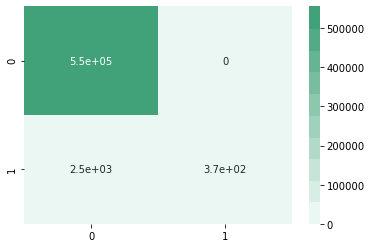

In [68]:
# confusion matrix
XGBmatrix = confusion_matrix(y_test2, XGB_pred)
print('Confusion matrix : \n',XGBmatrix)

# classification report for precision, recall f1-score and accuracy
XGBmatrix1 = classification_report(y_test2,XGB_pred)
print('Classification report : \n',GBMmatrix1)

cmap =  sns.diverging_palette(180, 150, s=80, l=60, n=20)
sns.heatmap(XGBmatrix, annot=True,  vmin=0, vmax=555719, center= 0, cmap=cmap)
plt.show()

## Feature Importances

In [69]:
# Extract feature importances
XGB_Feature_Imp = pd.DataFrame({'features': list(features),
                   'importance': XGB.feature_importances_}).\
                    sort_values('importance', ascending = False)
XGB_Feature_Imp.head()

features  importance
9   category_gas_transport    0.603616
11    category_grocery_pos    0.119826
0                 city_pop    0.067706
4                      day    0.066361
18   category_shopping_net    0.025320

## References

[1] https://www.analyticsvidhya.com/blog/2016/04/tree-based-algorithms-complete-tutorial-scratch-in-python/
    
[2] https://www.datacamp.com/community/tutorials/decision-tree-classification-python

[3] https://mljar.com/blog/visualize-decision-tree/

[4] https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

[5] https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
